## GC Unit Tests

In [1]:
import jax
from jax import random
import jax.numpy as jnp

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.utils import lwgt_to_prob, weighted_corr, argsort_marginal, continuous_cdf, interpolate_weights

## Gaussian Copula Resampling

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

import jax
from jax import random
import jax.numpy as jnp
# from jax.experimental import checkify
from functools import partial

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import warnings
warnings.filterwarnings("ignore")

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [24]:
@jax.jit
def continuous_cdf (xs, pi, u):
    """
    Return one sample from a continuous approximation of the ECDF of x.
    
    Should bbe trivial to extend to multiple samples if needed by: 
        list(map(lambda x: np.argmax(w_cdf > x), u))
        
    """
#     checkify.check(jnp.sum(weights) == 1, "weights must sum to 1")
    n = len(xs)

    w_cdf = jnp.cumsum(pi)
    r = np.argmax(w_cdf > u)
    u_new = (u - w_cdf[r-1]) / pi[r]
    
    # select region: 
    new_x = jax.lax.cond(
        r == 0,
        lambda _: xs[0],
        lambda _: jax.lax.cond(
            r == n,
            lambda _: xs[-1],
            lambda _: (xs[r] - xs[r-1]) * u_new + xs[r-1],
            r
        ),
        r
    )
    return new_x


def interpolate_weights (weights):
    """ Interpolate weights as in Malik&Pitt """
    n = len(weights) 
    pi = jnp.zeros(n + 1)
    pi = pi.at[0].set(weights[0] / 2)
    pi = pi.at[n].set(weights[-1] / 2)
    pi = pi.at[1:n].set((weights[:-1] + weights[1:]) / 2)
    return pi


@jax.jit
def jax_sort_marginal (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = jnp.stack((x, w)).T
    sorted_x, sorted_w = jax.lax.sort_key_val(x, w)
    return {"x": sorted_x, "w": sorted_w}


def argsort_marginal (x, w):
    """ sort (x,w) based on x and return the indices of the sort """
    sort_indices = jnp.argsort(x)
    return {"x": jnp.take(x, sort_indices),
            "w": jnp.take(w, sort_indices),
            "unsorted_x": x,
            "indices": sort_indices}


def quantile_func (x, sorted_samples, cumulative_weights):
    """
    x: vector of points to evaluate cdf
    cdf: {"x": sorted samples
          "w": cumulative sum of weights}
    """
    cdf_fn = jax.vmap(lambda y: cumulative_weights[jnp.argmax(sorted_samples == y)])
    return cdf_fn(x)


# @jax.jit
def weighted_corr (X, weights):
    """
    Return weighted correlation matrix
    """
    corr_mat = jnp.cov(X, aweights = weights)
    stddevs = jnp.sqrt(jnp.diag(corr_mat))
    corr_mat = corr_mat / stddevs[:, None] / stddevs[None, :]
    return corr_mat


# @jax.jit
def marginal_cdf (x, data, weights):
    return sum(jnp.where(data <= x, x = weights, y=0))


def gaussian_copula_test (key, X, weights, N):
    """
    Straightforward (numpy-ish) copula for testing
    """
    n, d = X.shape
    # estimate correlation matrix: 
    Y = np.zeros((d, n))
    for j in range(d):
        for i in range(n):
            Y[j, i] = marginal_cdf(X[i,j], X[:, j], weights)
    rho_hat = weighted_corr(jnp.array(Y), weights = weights)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = np.zeros(d), cov = rho_hat, shape = (N,))
    U = jax.scipy.stats.norm.cdf(Z)
    
    x_samples = np.zeros((d, N))
    for j in range(d): 
        sorted_marg = jax_sort_marginal(X[:, j], weights) # sort marginal f(x)
        interpolated_w = interpolate_weights(sorted_marg["w"]) # interpolate midpoints between weights
        for i in range(N):
            x_samples[j, i] = continuous_cdf(sorted_marg["x"], interpolated_w, U[i, j])

    return x_samples


def gaussian_copula (key, X, weights, N):
    """
    Estimate and sample from a Gaussian copula as follows: 
    
        - Find Y = (F_1(X_1), ..., F_d(X_d))
        - rho_hat = weighted correlation of Y 
        - Sample Z ~ N(0, rho_hat) N times
        - Create U = (phi(Z_1), ..., phi(Z_d))
        - Use inverse-CDF of marginals to create samples: (inv-CDF(U_1), ..., inv-CDF(U_d))
    
    Args:
        - key: 
        - X: 
        - weights:
        - N: Number of samples to generate from the GC
    """
    n, d = X.shape
    
    # sort marginals: 
    sorted_marginals = jax.vmap(
        argsort_marginal,
        in_axes = (1, None)
    )(X, weights)

    # estimate correlation matrix: 
    w_cumsum = jnp.cumsum(weights)
#     Y = jax.vmap(lambda ind: jnp.take(w_cumsum, ind, axis = 0), in_axes = (0, ))(sorted_marginals["indices"])
    Y = jax.vmap(
        lambda x, sorted_x, sorted_w: quantile_func(x, sorted_samples=sorted_x, cumulative_weights=jnp.cumsum(sorted_w)),
        in_axes = (0, 0, 0))(sorted_marginals["unsorted_x"], sorted_marginals["x"], sorted_marginals["w"])
    rho_hat = weighted_corr(Y, weights = weights)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = np.zeros(d), cov = rho_hat, shape = (N,))
    U = jax.scipy.stats.norm.cdf(Z)

    interpolated_weights = jax.vmap(interpolate_weights, in_axes = (0,))(sorted_marginals["w"])
    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], interpolated_weights, U)
    return x_samples

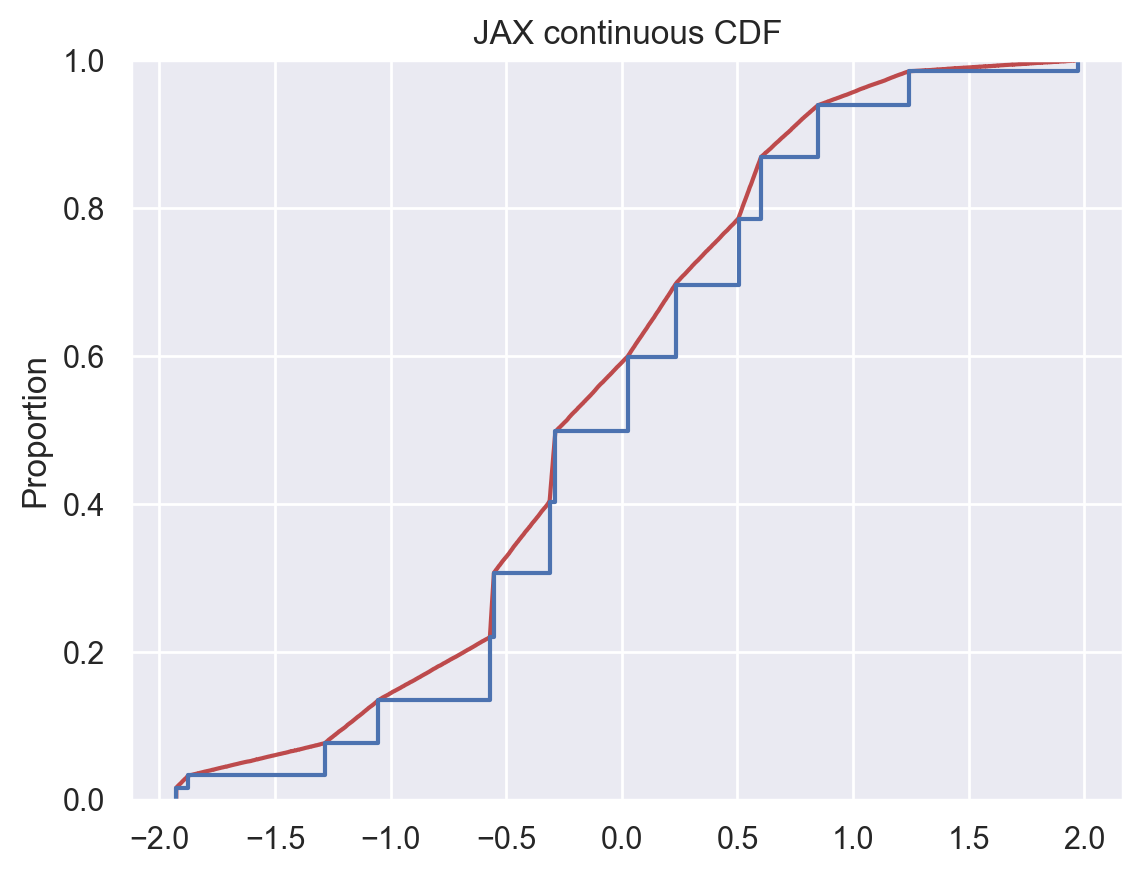

In [5]:
def sort_marginal_np (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = dict(zip(x, w))
    sorted_x_dict = dict(sorted(x_w.items(), key = lambda x: x[0]))
    sorted_x = jnp.array(list(sorted_x_dict.keys()))
    sorted_w = jnp.array(list(sorted_x_dict.values()))
    return sorted_x, sorted_w

# generate some data: 
N = 15
rv = norm()
x = rv.rvs(size=N)

w = rv.pdf(x)
w = w / sum(w)

sorted_x, sorted_w = sort_marginal_np(x, w)

sorted_x_jnp = jnp.array(sorted_x)
jnp_sorted_weights = jnp.array(sorted_w)
U = random.uniform(random.PRNGKey(0), shape = (100_000,))

# TODO: pass U as an array
jax_samples = jax.vmap(
    continuous_cdf,
    in_axes= (None, None, 0)
)(sorted_x_jnp, jnp_sorted_weights, U)

sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

# Gaussian Copula

- Find the inverse CDF for each marginal: 
    - Order each marginal and their corresponding weights: $(X^{(1)}_j, ..., X^{(n)}_j)$, $w_{1j}, ..., w_{nj}$ for $j=1,...,d$
- Estimate weighted correlation matrix, $\rho$
- Generate $Z \sim MVN(0, \rho)$
- Create uniforms using the Gaussian CDF as: $U = (\Phi(Z_1),..., \Phi(Z_d))$
- Use inverse CDF, $F^{-1}$ (`continuous_cdf`) to sample from ECDF as: $F^{-1}(X_j, w_j, U_j)$, for $j=1,...,d$

In [25]:
_cov = -1
mvn = stats.multivariate_normal(mean = [5, 0.4], cov = [[3, _cov], [_cov, 1]])
mvn2 = stats.multivariate_normal(mean = [1, 0.4], cov = [[2, 0], [0, 1]])
N = 100
X = mvn.rvs(N)
# X = np.random.random(size = (N, 2))
W = np.random.uniform(size=N)
W = W/sum(W)

In [26]:
gaussian_copula_test(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=10)

array([[ 4.95430621,  6.73518511,  5.25934459,  2.91761   ,  5.78401132,
         4.35603873,  4.7980309 ,  4.17307815,  4.3255647 ,  3.69015588],
       [-1.50363035, -0.15262033,  0.71491705,  1.8919831 , -1.50475099,
        -0.82256998,  1.93813373,  3.06980599, -0.29543963,  0.94342171]])

In [27]:
gaussian_copula(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=10)

DeviceArray([[ 4.95430621,  6.73518511,  5.25934459,  2.91761   ,
               5.78401132,  4.35603873,  4.7980309 ,  4.17307815,
               4.3255647 ,  3.69015588],
             [-1.50363035, -0.15262033,  0.71491705,  1.8919831 ,
              -1.50475099, -0.82256998,  1.93813373,  3.06980599,
              -0.29543963,  0.94342171]], dtype=float64)

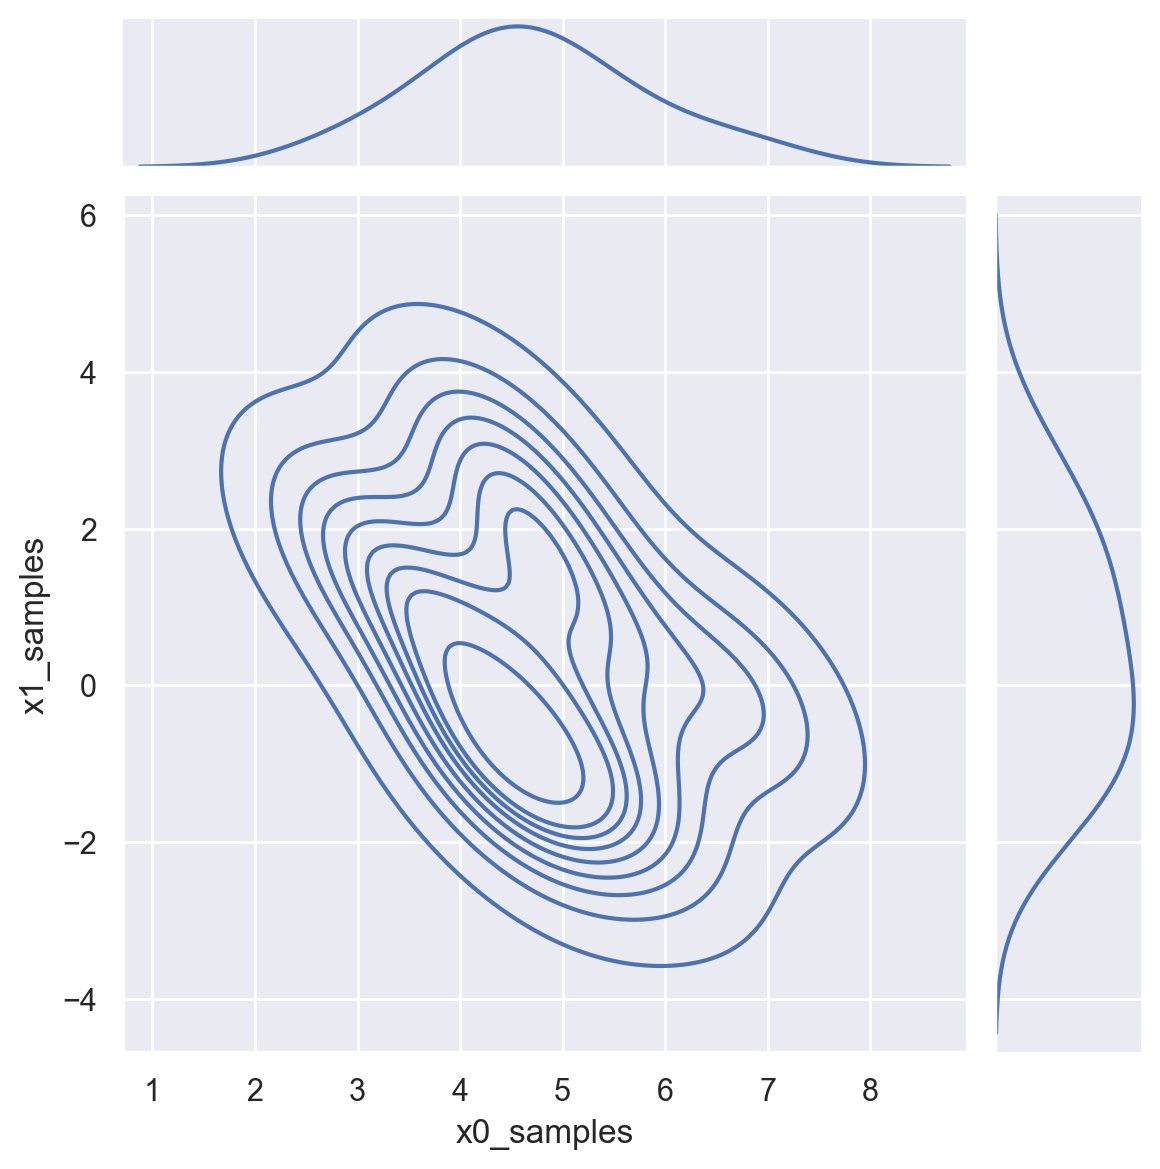

In [28]:
x_samples = gaussian_copula_test(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=10)
X_samples = pd.DataFrame(np.array(x_samples).T, columns = ["x0_samples", "x1_samples"])
sns.jointplot(x = "x0_samples", y = "x1_samples", data = X_samples, kind = "kde");

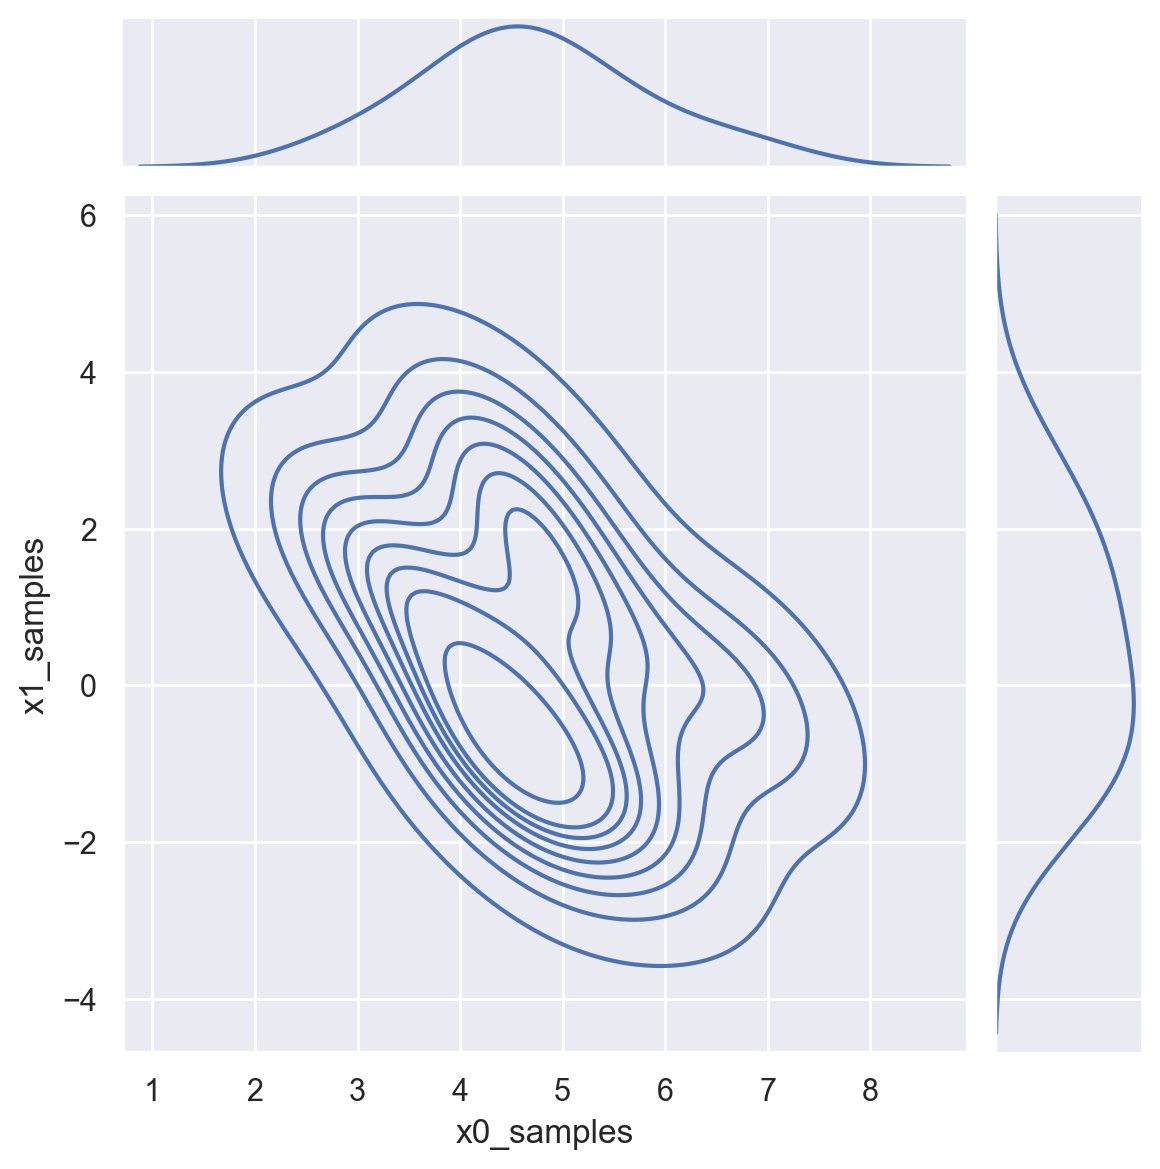

In [29]:
x_samples2 = gaussian_copula(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=10)
X_samples2 = pd.DataFrame(np.array(x_samples2).T, columns = ["x0_samples", "x1_samples"])
sns.jointplot(x = "x0_samples", y = "x1_samples", data = X_samples2, kind = "kde");

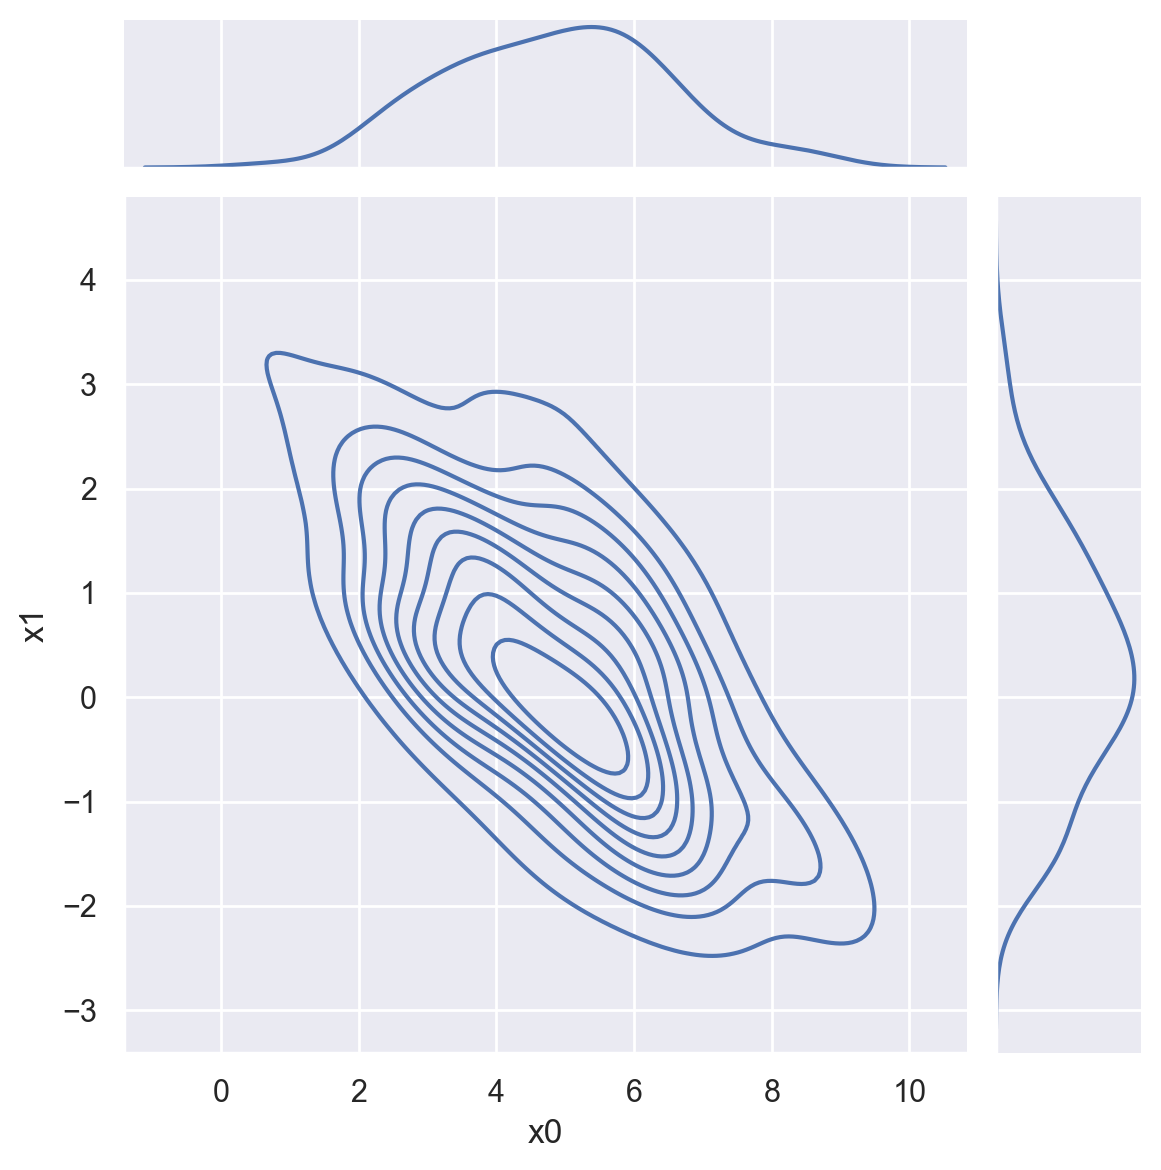

In [30]:
X_samples = pd.DataFrame(np.array(X), columns = ["x0", "x1"])
sns.jointplot(x = "x0", y = "x1", data = X_samples, kind = "kde");

In [31]:
print("Calculation 1: ", np.cov(x_samples)[1,0])
print("Calculation 2: ", np.cov(x_samples2)[1,0])
print("true: ", np.cov(X.T)[1,0])

Calculation 1:  -0.808930600825134
Calculation 2:  -0.808930600825134
true:  -1.1579341667621756


## Test

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax import models
import optax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1
n_obs = 100

key = random.PRNGKey(0)
key, subkey = random.split(key)

lotvol_model = models.LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)
y_meas_abs = jnp.abs(y_meas)

theta_lims = jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.01, 0.2],
    [0.01, 0.2],
    [0.2, 0.3],
    [0.2, 0.3]])

In [12]:

def continuous_cdf (xs, pi, u):
    """
    Return a sample from a continuous approximation of the ECDF of x.

    Args: 
        - xs: Marginals
        - pi: interpolated weights of each x. Should be of length: len(xs) + 1
        - u: U(0,1)
    
    Returns: 
        Sample
    """
    n = len(xs)    

    w_cdf = jnp.cumsum(pi)
    r = jnp.argmax(w_cdf > u)
    u_new = (u - w_cdf[r-1]) / pi[r]
    
    # select region: 
    new_x = jax.lax.cond(
        r == 0,
        lambda _: xs[0],
        lambda _: jax.lax.cond(
            r == n,
            lambda _: xs[-1],
            lambda _: (xs[r] - xs[r-1]) * u_new + xs[r-1],
            r
        ),
        r
    )
    return new_x


def interpolate_weights (weights):
    """ Interpolate weights as in Malik&Pitt """
    n = len(weights) 
    pi = jnp.zeros(n + 1)
    pi = pi.at[0].set(weights[0] / 2)
    pi = pi.at[n].set(weights[-1] / 2)
    pi = pi.at[1:n].set((weights[:-1] + weights[1:]) / 2)
    return pi


# def sort_marginal (x, weights):
#     r""" 
#     Sort X and return corresponding w
#     """
#     sorted_x, sorted_w = jax.lax.sort_key_val(x, weights)
#     return {"x": sorted_x, "w": sorted_w}

def argsort_marginal (x, w):
    """ sort (x,w) based on x and return the indices of the sort """
    sort_indices = jnp.argsort(x)
    return {"x": jnp.take(x, sort_indices),
            "w": jnp.take(w, sort_indices),
            "indices": sort_indices}


def weighted_corr (X, weights):
    r"""
    Return weighted correlation matrix
    """
    corr_mat = jnp.cov(X, aweights = weights)
    stddevs = jnp.sqrt(jnp.diag(corr_mat))
    corr_mat = corr_mat / stddevs[:, None] / stddevs[None, :]
    return corr_mat


def marginal_cdf (x, data, weights):
    r"""
    Return quantile of x given data and weights
    """
    return sum(jnp.where(data <= x, x = weights, y=0))

In [111]:
def resample_gaussian_copula(key, x_particles_prev, prob):
    r"""
    Particle resampler with Gaussian Copula distribution.

    Estimate and sample from a Gaussian copula as follows: 
        - Find Y = (F_1(X_1), ..., F_d(X_d))
        - rho_hat = weighted correlation of Y 
        - Sample Z ~ N(0, rho_hat) N times
        - Create U = (phi(Z_1), ..., phi(Z_d))
        - Use inverse-CDF of marginals to create samples: (inv-CDF(U_1), ..., inv-CDF(U_d))

    Args: 
        key: PRNG key
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.

    Returns: 
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.  These are sampled with replacement from `x_particles_prev` with probability vector `exp(logw) / sum(exp(logw))`.
            - `ancestors`: Vector of `n_particles` integers between 0 and `n_particles-1` giving the index of each element of `x_particles_prev` corresponding to the elements of `x_particles`.

    TODO: 
        - Should be able to use jnp.take() with the `continuous_cdf` block and remove a vmap
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    x_particles = x_particles_prev.reshape((n_particles, -1))
    d = x_particles.shape[-1]
#     prob = lwgt_to_prob(logw)
    
    # sort marginals: 
    sorted_marginals = jax.vmap(
        argsort_marginal,
        in_axes = (1, None)
    )(x_particles, prob)

    # estimate correlation matrix: 
    w_cumsum = jnp.cumsum(prob)
#     Y = jax.vmap(lambda ind: jnp.take(w_cumsum, ind, axis = 0), in_axes = (0, ))(sorted_marginals["indices"])

    Y = jax.vmap(
        lambda unsorted_x, sorted_x, sorted_index: jax.vmap(
            lambda x, w: w[jnp.argmax(sorted_x == x)],
            in_axes = (0, None)
        )(unsorted_x, jnp.cumsum(prob[sorted_index])),
        in_axes = (1, 0, 0,)
    )(x_particles, sorted_marginals["x"], sorted_marginals["indices"])
    
    print("sorted_marginals indices shape: ", sorted_marginals["indices"].shape)
    print("Y shape: ", Y.shape)
    print("prob shape: ", prob.shape)
    rho_hat = weighted_corr(Y, weights = prob)
    print("rho: ", rho_hat)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = jnp.zeros(d), cov = rho_hat, shape = (n_particles,))
    U = jax.scipy.stats.norm.cdf(Z)

    interpolated_weights = jax.vmap(interpolate_weights, in_axes = (0,))(sorted_marginals["w"])
    
    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], interpolated_weights, U)

    return {
        "Y": Y,
        "x_particles": jnp.reshape(jnp.transpose(x_samples), newshape=p_shape),
        "U": U,
        "weights": interpolated_weights
    }


# # @partial(jax.jit, static_argnums=(3,))
def resample_gaussian_copula2(key, x_particles_prev, prob):
    r"""
    Particle resampler with Gaussian Copula distribution.

    Estimate and sample from a Gaussian copula as follows: 
        - Find Y = (F_1(X_1), ..., F_d(X_d))
        - rho_hat = weighted correlation of Y 
        - Sample Z ~ N(0, rho_hat) N times
        - Create U = (phi(Z_1), ..., phi(Z_d))
        - Use inverse-CDF of marginals to create samples: (inv-CDF(U_1), ..., inv-CDF(U_d))

    Args: 
        key: PRNG key
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.

    Returns: 
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.  These are sampled with replacement from `x_particles_prev` with probability vector `exp(logw) / sum(exp(logw))`.
            - `ancestors`: Vector of `n_particles` integers between 0 and `n_particles-1` giving the index of each element of `x_particles_prev` corresponding to the elements of `x_particles`.
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    x_particles = x_particles_prev.reshape((n_particles, -1))
    d = x_particles.shape[-1]
#     prob = lwgt_to_prob(logw)

    # estimate correlation matrix: 
    Y = jax.vmap(
        lambda x: 
        jax.vmap(
            marginal_cdf,
            in_axes = (0, None, None)
        )(x, x, prob),
        in_axes = (1))(x_particles)
    rho_hat = weighted_corr(Y, weights = prob)
    print("rho: ", rho_hat)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = jnp.zeros(d), cov = rho_hat, shape = (n_particles,))
    U = jax.scipy.stats.norm.cdf(Z)

    sorted_marginals = jax.vmap(
        argsort_marginal,
        in_axes = (-1, None)
    )(x_particles, prob)

    interpolated_weights = jax.vmap(interpolate_weights, in_axes = (0,))(sorted_marginals["w"])
    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], interpolated_weights, U)

    return {
        "Y": Y,
        "x_particles": jnp.reshape(jnp.transpose(x_samples), newshape=p_shape),
        "U": U,
        "weights": interpolated_weights
    }

def lotvol_neg_loglik(theta, model = lotvol_model, resampler = resampler.resample_mvn, n_particles=25):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler)
    return -temp["loglik"]

In [3]:
print(lotvol_neg_loglik(theta))

print(lotvol_neg_loglik(theta, resampler = resampler.resample_gaussian_copula))

print(lotvol_neg_loglik(theta, resampler = resample_gaussian_copula2))

68.79495
sorted_marginals indices shape:  (2, 25)
Y shape:  (2, 25)
prob shape:  (25,)
rho:  Traced<ShapedArray(float32[2,2])>with<DynamicJaxprTrace(level=1/0)>
weights:  Traced<ShapedArray(float32[2,26])>with<DynamicJaxprTrace(level=1/0)>
104.93817
rho:  Traced<ShapedArray(float32[2,2])>with<DynamicJaxprTrace(level=1/0)>
weights:  Traced<ShapedArray(float32[2,26])>with<DynamicJaxprTrace(level=1/0)>
73.6201


In [47]:
particles = np.random.multivariate_normal(size=(5, ), mean = [0, 5], cov=np.eye(2))
weights = jnp.array([0.01, 0.19, 0.1, 0.2, 0.5])

In [55]:
print(particles[:,1])
print(jnp.argsort(particles[:,1]))

[3.14327517 4.89444051 5.53871311 4.00812407 4.69400143]
[0 3 4 1 2]


In [62]:
print(particles[:,0])
print(jnp.argsort(particles[:,0]))
print(sorted(particles[:,0]))
print(particles[:,0][jnp.argsort(particles[:,0])])

[ 0.13911313 -1.29461864 -1.14398309  0.65659553  0.25110117]
[1 2 0 4 3]
[-1.2946186433478553, -1.1439830896908831, 0.13911312538291098, 0.25110117301363094, 0.6565955314959282]
[-1.29461864 -1.14398309  0.13911313  0.25110117  0.65659553]


In [57]:
sum(jnp.where(particles[:,0] <= 0.13911313, x = weights, y=0))

DeviceArray(0.3, dtype=float32)

In [68]:
jnp.take(jnp.cumsum(weights), jnp.where(particles[:,0][jnp.argsort(particles[:,0])] == particles[0,0])[0][0])
# jnp.where(particles[:,0][jnp.argsort(particles[:,0])] == particles[0,0])[0][0]

DeviceArray(0.3, dtype=float32)

In [103]:
c2 = resample_gaussian_copula2(key, particles, weights)

c2["Y"]

rho:  [[ 1.0000001  -0.75061756]
 [-0.75061756  1.0000001 ]]


DeviceArray([[0.3       , 0.19      , 0.29      , 1.        , 0.8       ],
             [0.01      , 0.9       , 1.        , 0.21000001, 0.71000004]],            dtype=float32)

In [112]:
c1 = resample_gaussian_copula(key, particles, weights)
c1["Y"]

sorted_marginals indices shape:  (2, 5)
Y shape:  (2, 5)
prob shape:  (5,)
rho:  [[ 1.         -0.75061756]
 [-0.7506176   1.0000001 ]]


DeviceArray([[0.29999998, 0.19      , 0.29      , 0.99999994, 0.79999995],
             [0.01      , 0.9       , 1.        , 0.21000001, 0.71000004]],            dtype=float32)

# Deprecated

In [ ]:
def jax_cont_resample (weights, xs, key):
    """
    Change `seed` to `key`
    """
    n = len(weights)
    u_new = jnp.zeros(n)
    u0 = random.uniform(key)
    u = (u0 + np.arange(n)) / n
    u = jnp.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
    
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
    def region_mid (k, val):
        xs = val["x"]
        r = val["r"]
        u_new = val["u_new"]
        return (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    
    def while_loop_func (val):
        u_j = val["u"][val["j"]]
        pi_i = val["pi"][val["i"]]
        
        val["r"] = val["r"].at[val["j"]].set(val["i"])
        val["u_new"] = val["u_new"].at[val["j"]].set((u_j - (val["s"] - pi_i)) / pi_i)
        
        # select region: 
        new_x = jax.lax.cond(
            val["r"][val["j"]] == 0,
            lambda _: val["x"][0],
            lambda _: jax.lax.cond(
                val["r"][val["j"]] == n,
                lambda _: val["x"][-1],
                lambda _: region_mid(val["j"], val),
                val
            ),
            val
        )
        val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
        val["j"] += 1
        return val 

    def while_cond (val):
        return jnp.logical_and(val["j"] <= n, val["u"][val["j"]] <= val["s"])
    
    def for_loop_func (i, val):
        val["s"] += val["pi"][i]
        val["i"] = i
        val = jax.lax.while_loop(while_cond, while_loop_func, val)
        return val
 
    init_val = {
        "j": 0,
        "r": jnp.zeros(n, int),
        "s": 0,
        "i": 0,
        "u": u,
        "u_new": jnp.zeros(n),
        "x": xs,
        "x_new": jnp.zeros(n),
        "pi": pi}
    
    val = jax.lax.fori_loop(0, n, for_loop_func, init_val)

    # select region: 
    new_x = jax.lax.cond(
        val["r"][val["j"]] == 0,
        lambda _: val["x"][0],
        lambda _: jax.lax.cond(
            val["r"][val["j"]] == n,
            lambda _: val["x"][-1],
            lambda _: region_mid(val["j"], val),
            val
        ),
        val
    )
    val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
    
    return val["x_new"]

def continuous_stratified_resample(weights, xs):
    """
    Args: 
        - weights: normalized weights with indices corresponding to xs. This is represented by \pi in the paper
        - xs: samples sorted in ascending order. Represented by x^{(k)} in the paper. 

    """
    n = len(weights)
    u0 = np.random.uniform(size=1)
    u = (u0 + np.arange(n)) / n
    u = np.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
#     print(u)
    
    # A.1: general form of continuous distribution
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2

    # A.3
    r = np.zeros(n)
    u_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            j = j + 1

    r = r.astype(int)

    x_new = np.zeros(n)
    for k in range(n):
        if r[k] == 0:
            x_new[k] = xs[0]
        elif r[k] == n:
            x_new[k] = xs[-1]
        else:
            x_new[k] = (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    return x_new

In [ ]:
N = 25
rv = norm()
x = rv.rvs(size=N)
print(x)

w = rv.pdf(x)
w = w / sum(w)
print(w)

x_dict = dict(zip(x, w))
print(x_dict.keys())

sorted_x_dict = dict(sorted(x_dict.items(), key = lambda x: x[0]))
sorted_x = np.array(list(sorted_x_dict.keys()))
sorted_weights = np.array(list(sorted_x_dict.values()))
sorted_x_dict

In [ ]:
print("Numpy version (fixed U): ", continuous_stratified_resample(sorted_weights, sorted_x))

print("JAX version (fixed U): ", jax_cont_resample(jnp.array(sorted_weights), 
                                                   jnp.array(sorted_x), 
                                                   key = random.PRNGKey(0)))


x_new_samples = [continuous_stratified_resample(sorted_weights, sorted_x) for i in range(200)]
x_new_samples = np.array(x_new_samples).flatten()

sns.ecdfplot(x=x_new_samples, alpha=0.8, color='firebrick').set(title = 'numpy continuous CDF')
sns.ecdfplot(x=x, weights = w);


keys = jax.random.split(random.PRNGKey(0), 200)
jax_x_new_samples = [jax_cont_resample(sorted_weights, sorted_x, key = keys[i]) for i in range(200)]
jax_x_new_samples = np.array(jax_x_new_samples).flatten()

sns.ecdfplot(x=jax_x_new_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

In [ ]:
## TEST: check weighted correlation matrix 

rho_hat = np.cov([u0, u1], aweights = W)
_vars = np.diag(np.cov([u0, u1], aweights = W))
rho_hat[0, 1] = rho_hat[0, 1] / np.sqrt(_vars[0] * _vars[1])
rho_hat[1, 0] = rho_hat[0, 1]
rho_hat[0,0] = 1
rho_hat[1,1] = 1
print(rho_hat)

rho_hat = np.cov([u0, u1], aweights = W)
stddevs = np.sqrt(np.diag(rho_hat))
print(rho_hat / stddevs[:, None] / stddevs[None, :])


# TEST: check ECDF
x0_ecfd = lambda x: sum(W[X[:, 0] < x])
x1_ecfd = lambda x: sum(W[X[:, 1] < x])

u0 = list(map(x0_ecfd, X[:,  0]))
u1 = list(map(x1_ecfd, X[:,  1]))

In [ ]:
%%time
# estimate correlation matrix: 
Y = jax.vmap(
    lambda x: 
    jax.vmap(
        marginal_cdf,
        in_axes = (0, None, None)
    )(x, x, jnp.array(W)),
    in_axes = (1))(X)
rho_hat = weighted_corr(Y, weights = W)

Z = np.random.multivariate_normal(mean = np.zeros(rho_hat.shape[0]), cov = rho_hat, size = 20_000)

# gaussian copula: 
std_normal = norm()
U = std_normal.cdf(Z)

sorted_marginals = jax.vmap(
    jax_sort_marginal,
    in_axes = (1, None)
)(jnp.array(X), jnp.array(W))

x_samples = jax.vmap(
    lambda x, w, u: jax.vmap(
        continuous_cdf,
        in_axes= (None, None, 0)
    )(x, w, u),
    in_axes = (0, 0, 1))(sorted_marginals["x"], sorted_marginals["w"], U)

In [ ]:
# %%time
# # estimate CDF for each margin: 

# # X0: 
# x0 = X[:, 0]
# w0 = norm(loc = np.mean(x0), scale = np.std(x0)).pdf(x0)
# w0 = w0 / sum(w0) # normalized weights: 

# # sort x and w:
# x0_w0 = dict(zip(x0, w0))
# sorted_x0_dict = dict(sorted(x0_w0.items(), key = lambda x: x[0]))
# sorted_x0 = jnp.array(list(sorted_x0_dict.keys()))
# sorted_w0 = jnp.array(list(sorted_x0_dict.values()))

# U = random.uniform(random.PRNGKey(0), shape = (10_000,))

# jax_samples = jax.vmap(
#     continuous_cdf,
#     in_axes= (None, None, 0)
# )(sorted_x0, sorted_w0, U)

# sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF');
# sns.ecdfplot(x=x0, weights = w0, alpha=0.8);


# # X1: 
# x1 = X[:, 1]
# w1 = norm(loc = np.mean(x1), scale = np.std(x1)).pdf(x1)
# w1 = w1 / sum(w1) # normalized weights: 

# # sort x and w:
# x1_w1 = dict(zip(x1, w1))
# sorted_x1_dict = dict(sorted(x1_w1.items(), key = lambda x: x[0]))
# sorted_x1 = jnp.array(list(sorted_x1_dict.keys()))
# sorted_w1 = jnp.array(list(sorted_x1_dict.values()))

# U = random.uniform(random.PRNGKey(0), shape = (10_000,))

# jax_samples = jax.vmap(
#     continuous_cdf,
#     in_axes= (None, None, 0)
# )(sorted_x1, sorted_w1, U)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey = True)
# sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick', ax = ax).set(title = 'JAX continuous CDF');
# sns.ecdfplot(x=x1, weights = w1, alpha=0.4, ax = ax);